In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import tensorflow as tf
from tensorflow import keras
import PIL
import IPython
import kerastuner as kt

from keras.models import Model, Input, load_model

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import TensorBoard

In [2]:
root_dir = "G:/dataset/panicle_period"
train_dir = os.path.join(root_dir, "train")
val_dir = os.path.join(root_dir, "val")
test_dir = os.path.join(root_dir, "test")

print(os.path.exists(train_dir))
print(os.path.exists(val_dir))
print(os.path.exists(test_dir))

print(os.listdir(train_dir))
print(os.listdir(test_dir))
print(os.listdir(val_dir))

True
True
True
['1', '2', '3']
['1', '2', '3']
['1', '2', '3']


In [3]:
width = 224
height = 224
channels = 3

EPOCHS = 40
num_classes = 3
BATCH_SIZE = 32

save_path = './save_weights/VGG16-{epoch:02d}-{val_accuracy:.2f}.h5'

In [4]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
#     rescale=1./255,
    preprocessing_function=keras.applications.vgg16.preprocess_input,
#     rotation_range=3,
#      width_shift_range=0.02,
#      height_shift_range=0.02,
#     zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
#     brightness_range = (1, 1.1),
#     fill_mode='nearest'
)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(height, width),
                                                    batch_size=BATCH_SIZE,
                                                    seed=7,
                                                    shuffle=True,
                                                    color_mode="rgb",
                                                    class_mode="categorical")
test_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=keras.applications.vgg16.preprocess_input,
#     rescale=1./255,
)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                    target_size=(height, width),
                                                    batch_size=BATCH_SIZE,
                                                    seed=7,
                                                    shuffle=False,
                                                    color_mode="rgb",
                                                    class_mode="categorical")
val_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=keras.applications.vgg16.preprocess_input,
)
val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(height, width),
                                                batch_size=BATCH_SIZE,
                                                seed=7,
                                                shuffle=False,
                                                color_mode="rgb",
                                                class_mode="categorical")
train_num = train_generator.samples
test_num = test_generator.samples
val_num = val_generator.samples

print(train_num, test_num, val_num)
print(train_generator[0][0].shape)
print(train_generator.class_indices)

Found 39688 images belonging to 3 classes.
Found 13231 images belonging to 3 classes.
Found 13231 images belonging to 3 classes.
39688 13231 13231
(32, 224, 224, 3)
{'1': 0, '2': 1, '3': 2}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


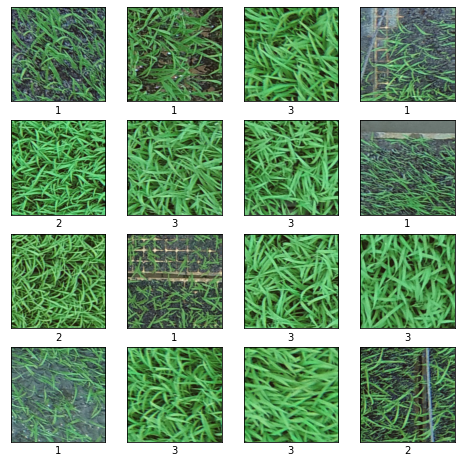

In [5]:
class_names = ['1', '2', '3']

plt.figure(figsize=(8,8))
for i in range(16):
    x = 1
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((train_generator[i][0][x]+127.5)/255, cmap=plt.cm.binary)
    plt.xlabel(class_names[np.argmax(train_generator[i][1][x])])
plt.show()

In [6]:
# 平衡数据集
# filenames = tf.io.gfile.glob(str(train_dir + '/*/*'))

# COUNT_1 = len([filename for filename in filenames if "0-20" in filename])
# print("0-20 images count in training set: " + str(COUNT_1))

# COUNT_2 = len([filename for filename in filenames if "21-40" in filename])
# print("21-40 images count in training set: " + str(COUNT_2))

# COUNT_3 = len([filename for filename in filenames if "41-60" in filename])
# print("41-60 images count in training set: " + str(COUNT_3))

# COUNT_4 = len([filename for filename in filenames if "61-80" in filename])
# print("61-80 images count in training set: " + str(COUNT_4))

# # 平衡数据集
# weight_for_0 = (1 / COUNT_1)*(train_num)/4.0 
# weight_for_1 = (1 / COUNT_2)*(train_num)/4.0
# weight_for_2 = (1 / COUNT_3)*(train_num)/4.0 
# weight_for_3 = (1 / COUNT_4)*(train_num)/4.0 

# class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3}

# print('Weight for class 0: {:.2f}'.format(weight_for_0))
# print('Weight for class 1: {:.2f}'.format(weight_for_1))
# print('Weight for class 2: {:.2f}'.format(weight_for_2))
# print('Weight for class 3: {:.2f}'.format(weight_for_3))

In [7]:
def display_training_curves(training, validation, title, subplot):
    if subplot % 10 == 1:  # set up the subplots on the first call
        plt.subplots(figsize=(10, 10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model ' + title)
    ax.set_ylabel(title)
    # ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [8]:
lr_callback = ReduceLROnPlateau(monitor='val_loss',
                                patience=3,
                                verbose=1,
                                factor=0.2,
                                min_lr=0.000001)
# 设置模型保存路径，且根据val_acc保存最优模型
checkpoint = ModelCheckpoint(
                                filepath=save_path,
                                monitor='val_accuracy', 
                                save_weights_only=False, 
                                save_best_only=True, 
                                mode='auto',
                                period=3
                            )

# tbCallBack = TensorBoard(log_dir='g:/logs')

In [9]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense, Flatten
# from tensorflow.keras.layers.pooling import MaxPooling2D

# def create_model(hp):
def create_model():
    
    pretrained_model = tf.keras.applications.VGG16(weights='imagenet', 
                                                   input_shape=[width, height, 3], 
                                                   include_top=False)
    pretrained_model.trainable = False
    
#     hp_units = hp.Int('units', min_value = 32, max_value = 256, step = 32)
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(units = 32, activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation='softmax',
                              kernel_regularizer='l2'
                             )
    ])

#     hp_learning_rate = hp.Choice('learning_rate', values = [1e-3, 1e-4])
    model.compile(
        optimizer = 'adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [10]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 512)         2048      
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                16416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9

In [11]:
history1 = model.fit(train_generator,
                     steps_per_epoch=train_num // BATCH_SIZE,
                     validation_data=test_generator,
                     validation_steps=test_num // BATCH_SIZE, 
                     epochs=EPOCHS,
                     verbose=1,
#                      class_weight=class_weight,
                     callbacks=[checkpoint, lr_callback])

Epoch 1/40
1240/1240 [==============================] - 485s 391ms/step - loss: 0.4524 - accuracy: 0.8284 - val_loss: 0.2910 - val_accuracy: 0.8969
Epoch 2/40
1240/1240 [==============================] - 486s 392ms/step - loss: 0.3693 - accuracy: 0.8605 - val_loss: 0.2612 - val_accuracy: 0.9084
Epoch 3/40
1240/1240 [==============================] - 451s 363ms/step - loss: 0.3410 - accuracy: 0.8705 - val_loss: 0.2439 - val_accuracy: 0.9146
Epoch 4/40
1240/1240 [==============================] - 481s 388ms/step - loss: 0.3342 - accuracy: 0.8718 - val_loss: 0.2331 - val_accuracy: 0.9192
Epoch 5/40
 516/1240 [===========>..................] - ETA: 4:19 - loss: 0.3275 - accuracy: 0.8765

KeyboardInterrupt: 

In [ ]:
final_accuracy = history1.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))
display_training_curves(history1.history['accuracy'][1:], history1.history['val_accuracy'][1:], 'accuracy', 211)
display_training_curves(history1.history['loss'][1:], history1.history['val_loss'][1:], 'loss', 212)

### 评估准确率
接下来，比较模型在测试数据集上的表现：

In [ ]:
val_loss, val_acc = model.evaluate(val_generator)

print('\nTest accuracy:', val_acc)
print('\nTest loss:', val_loss)

In [ ]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(val_generator)
predictions.shape
predictions[0]
np.argmax(predictions[0])
val_generator.labels[0]

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label, img
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label
  plt.grid(False)
  plt.xticks(range(4))
  plt.yticks([])
  thisplot = plt.bar(range(4), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [ ]:
x = 6
i = 10
index = (x+1)*16+i-1
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[index], np.argmax(val_generator[x][1][i]), (val_generator[x][0][i]+127.5)/255)
plt.subplot(1,2,2)
plot_value_array(i, predictions[index],  np.argmax(val_generator[x][1][i]))
plt.show()